In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP
np.random.seed(42)
%matplotlib inline

In [2]:
xo.__version__

'0.2.4'

In [3]:
data_dir = '/Users/mbedell/python/pmodes/experiments/data/'
import utils

In [4]:
d = np.genfromtxt(data_dir+'sim_oneyear.csv', names=True, dtype=None, delimiter=',')
ts_all = np.copy(d['ts'])
rvs_all = np.copy(d['rvs'])
xs_all = np.copy(d['xs'])

In [5]:
rvs_noiseless = np.copy(rvs_all)
rvs_all += np.random.normal(0., 1.0, len(rvs_all)) # photon noise - 1 m/s for 1-minute

In [6]:
time_per_night = 45. * 60. # seconds
nights_per_year = 60
integrated_kernel = False # for the > 1 minute exposures only

#### observe for N consecutive 1-min integrations every night

In [7]:
start_ts_nightly = np.arange(30,30+nights_per_year) * 3600. * 24. # nightly on consecutive nights
start_ts_nightly += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
assert np.isin(start_ts_nightly, ts_all).all(), "Bad timestamp!"

In [8]:
exp_time = 1. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)
t = np.ravel([np.arange(n_exp) * 60. + tt for tt in start_ts_nightly])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])
yerr = np.zeros_like(t) + 1.0

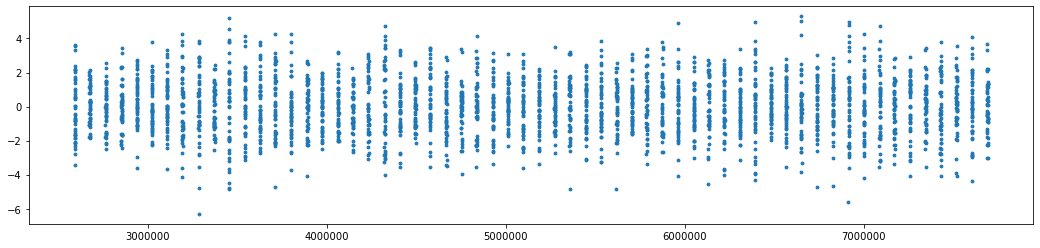

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(18,4))
ax.scatter(t, y, s=8);

In [10]:
t_grid = utils.make_t_grid(start_ts_nightly, time_per_night)

In [11]:
y_pred, mu, sd = utils.gp_predict(t, y, yerr, t_grid, integrated=False)

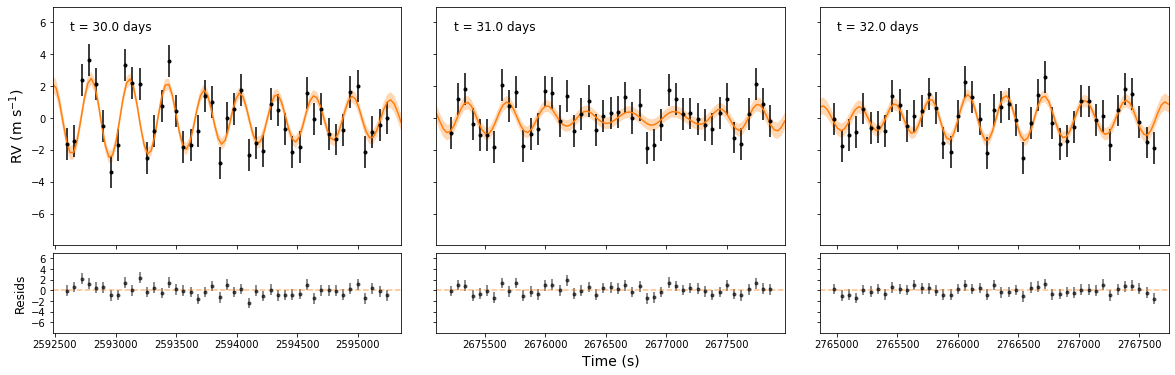

In [12]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts_nightly, t_grid, mu, sd, time_per_night=time_per_night)

In [13]:
print("net RMS = {0:.2f} m/s".format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

net RMS = 1.04 m/s


#### N consecutive observations per night, but random nights

In [14]:
start_ts_random = np.random.choice(360, nights_per_year, replace=False) * 3600. * 24. # nightly for random nights (we're gonna ignore seasons)
start_ts_random += np.random.randint(-60, 60, 60)*60. # random perturbation of up to an hour before/after - can only be whole minutes to avoid interpolation
start_ts_random.sort()
assert np.isin(start_ts_random, ts_all).all(), "Bad timestamp!"

In [15]:
exp_time = 1. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)
t = np.ravel([np.arange(n_exp) * 60. + tt for tt in start_ts_random])
y = np.ravel([rvs_all[ts_all == tt] for tt in t])
yerr = np.zeros_like(t) + 1.0

In [16]:
t_grid = utils.make_t_grid(start_ts_random, time_per_night)

In [17]:
y_pred, mu, sd = utils.gp_predict(t, y, yerr, t_grid, integrated=False)

In [18]:
# HACK:
if np.sum(np.isfinite(y_pred)) < len(y_pred):
    y_pred[~np.isfinite(y_pred)] = 0.0

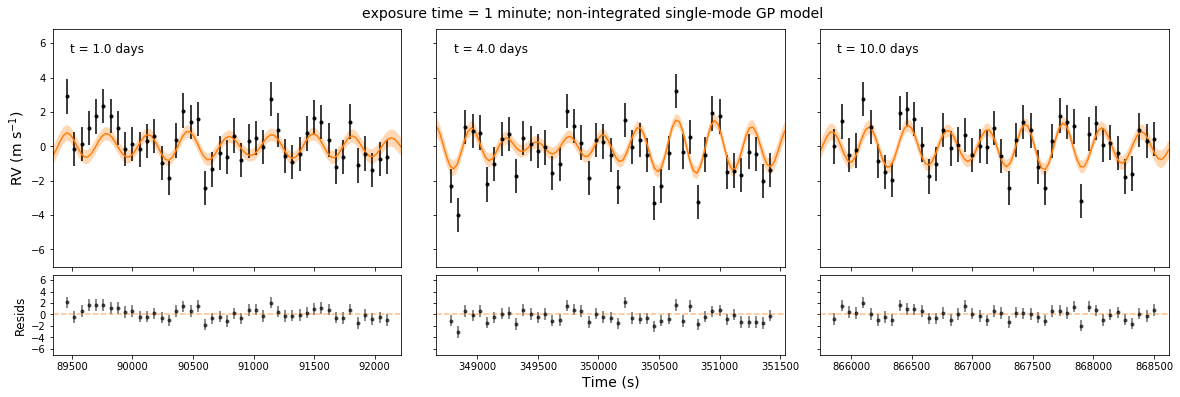

In [19]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts_random, t_grid, mu, sd, time_per_night=time_per_night)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14)
fig.savefig('randomnights_1min_nonintegrated.png');

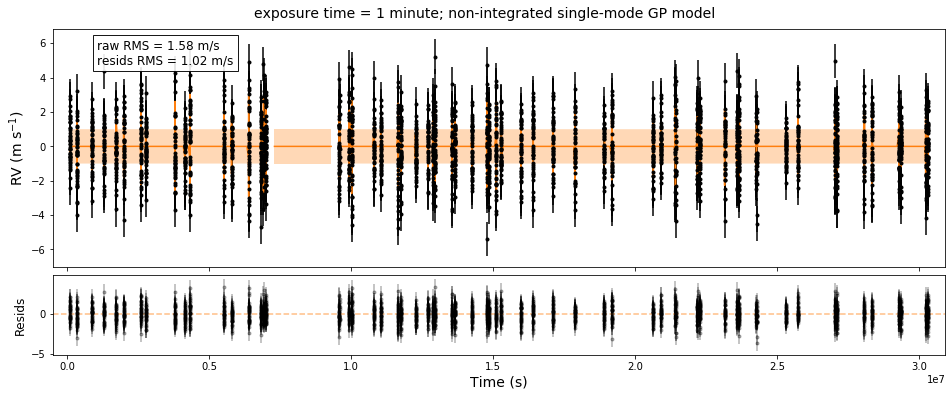

In [20]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts_random, t_grid, mu, sd)
fig.suptitle('exposure time = 1 minute; non-integrated single-mode GP model', y=0.93, fontsize=14)
fig.savefig('randomnights_1min_nonintegrated_full.png');

#### random nights, longer exposures

In [21]:
exp_time = 3. * 60. # seconds per exposure
n_exp = int(time_per_night/exp_time)

t = []
y = []

for st in start_ts_random:
    inds = (ts_all > st - 1800.) & (ts_all < st + time_per_night + 1800.)
    for n in range(n_exp):
        stt = st + n*exp_time # start time for this exposure, assumes no read time
        y.append(utils.simulate_exposure(ts_all[inds], rvs_all[inds], stt, exp_time))
        t.append(stt + exp_time/2.)
        
t = np.ravel(t)
y = np.ravel(y)
yerr = np.zeros_like(t) + 1.0 / np.sqrt(exp_time/60.)

In [33]:
1.0 / np.sqrt(exp_time/60.)

0.5773502691896258

In [22]:
t_grid = utils.make_t_grid(start_ts_random, time_per_night)

In [23]:
y_pred, mu, sd = utils.gp_predict(t, y, yerr, t_grid, integrated=integrated_kernel, exp_time=exp_time)

In [24]:
# HACK:
if np.sum(np.isfinite(y_pred)) < len(y_pred):
    y_pred[~np.isfinite(y_pred)] = 0.0

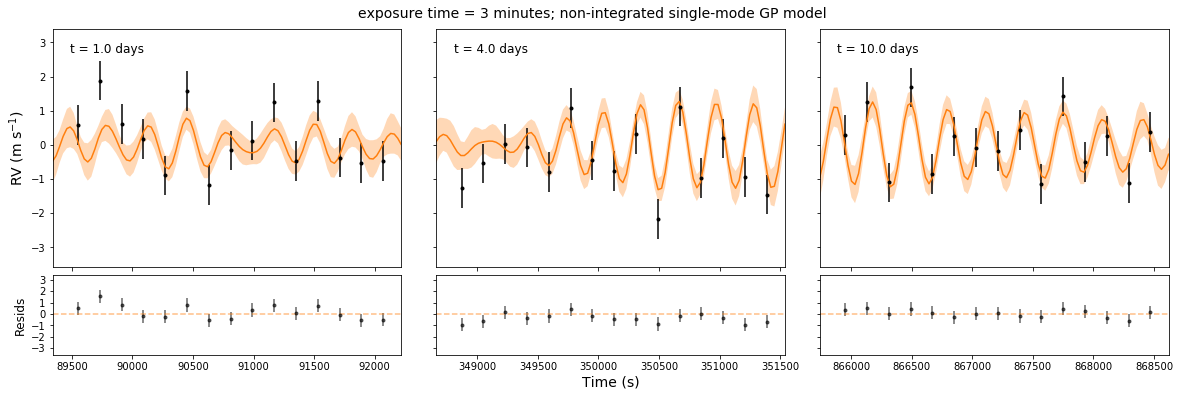

In [25]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts_random, t_grid, mu, sd, time_per_night=time_per_night)
if integrated_kernel:
    fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('randomnights_{0:.0f}min_integrated.png'.format(exp_time/60.));
else:
    fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('randomnights_{0:.0f}min_nonintegrated.png'.format(exp_time/60.));

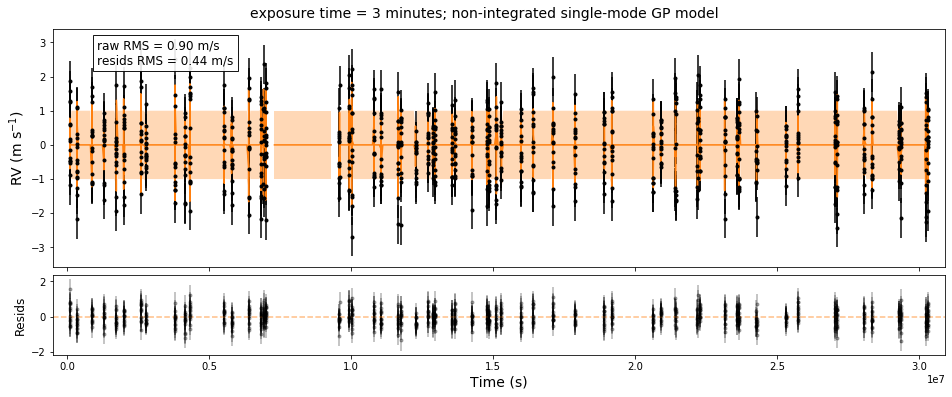

In [26]:
fig = utils.plot_year(t, y, yerr, y_pred, start_ts_random, t_grid, mu, sd)
if integrated_kernel:
    fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('randomnights_{0:.0f}min_integrated_full.png'.format(exp_time/60.));
else:
    fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14)
    fig.savefig('randomnights_{0:.0f}min_nonintegrated_full.png'.format(exp_time/60.));

#### consecutive nights, longer exposures

In [27]:
t = []
y = []

for st in start_ts_nightly:
    inds = (ts_all > st - 1800.) & (ts_all < st + time_per_night + 1800.)
    for n in range(n_exp):
        stt = st + n*exp_time # start time for this exposure, assumes no read time
        y.append(utils.simulate_exposure(ts_all[inds], rvs_all[inds], stt, exp_time))
        t.append(stt + exp_time/2.)
        
t = np.ravel(t)
y = np.ravel(y)
yerr = np.zeros_like(t) + 1.0 / np.sqrt(exp_time/60.)

In [28]:
t_grid = utils.make_t_grid(start_ts_nightly, time_per_night)

In [29]:
y_pred, mu, sd = utils.gp_predict(t, y, yerr, t_grid, integrated=integrated_kernel, exp_time=exp_time)

In [30]:
# HACK:
if np.sum(np.isfinite(y_pred)) < len(y_pred):
    y_pred[~np.isfinite(y_pred)] = 0.0

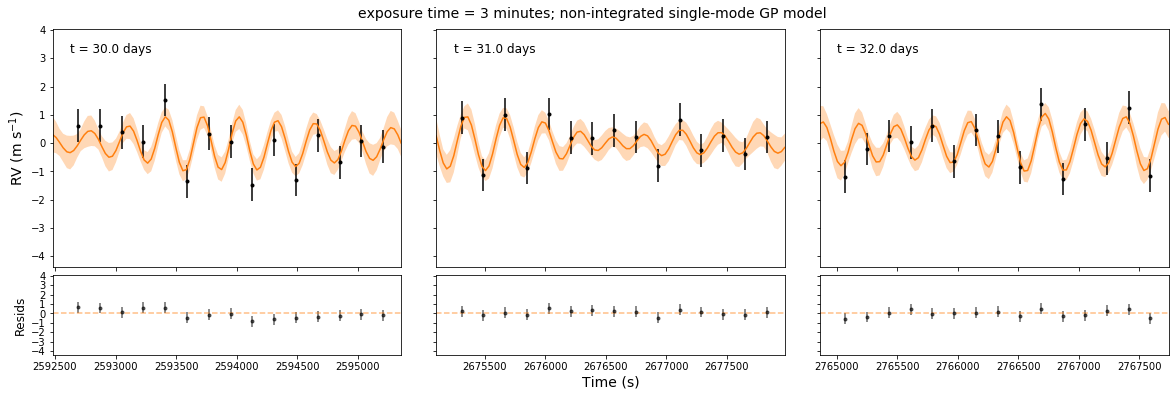

In [31]:
fig = utils.plot_nights(t, y, yerr, y_pred, start_ts_nightly, t_grid, mu, sd, time_per_night=time_per_night)
if integrated_kernel:
    fig.suptitle('exposure time = {0:.0f} minutes; integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14);
else:
    fig.suptitle('exposure time = {0:.0f} minutes; non-integrated single-mode GP model'.format(exp_time/60.), y=0.93, fontsize=14);

In [32]:
print('RMS = {0:.2f} m/s'.format(np.sqrt(np.sum((y - y_pred)**2/len(y)))))

RMS = 0.45 m/s
